# Name: David Crow
# CSCE 823 Assignment 2

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from keras import initializers, losses, metrics, optimizers

import keras

Using TensorFlow backend.


In [2]:
print("TensorFlow: {}".format(tf.__version__))
print("Keras: {}\n".format(keras.__version__))

print("Hardware:\n")
print(device_lib.list_local_devices())

TensorFlow: 1.13.1
Keras: 2.2.4

Hardware:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13161048696456533829
]


### 0: Set the global flag

In [3]:
RUN_CONFIGURATION_LOOP = True

### 1: Load the datasets

In [4]:
non_test_data = pd.read_csv("non-test-data.csv")
test_data = pd.read_csv("test-data.csv")

### 2: Explore the data

### 2a: Build a function to return the value of $z$ from the value of the mathematical saddle function

In [5]:
def compute_z(data):
    return data["x1"] ** 2 - data["x2"] ** 2

### 2b: Build a function to display a 3D representation of the saddle

In [6]:
"""
I really did try to make my plots interactive. However, I worked on this assigment on both a MacBook and
a Windows 10 computer, and it was a bit painful to make the flags (i.e. the Jupyter magic) work correctly
on both devices.
"""

def surface_plot(x, y, z, xlabel="\n$x_1$", ylabel="\n$x_2$", zlabel="\n$y$"):
    # create the figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection="3d")
    
    # pretty-fy the subplot
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_ylim(-1, 1)
    
    # plot and return the 3D surface
    ax.plot_trisurf(x, y, z, cmap=cm.Blues, alpha=0.7)
    
    return ax

### 2c: Visually explore the non-test data using both 2D representations and 3D representations

The instructions for this step aren't 100% clear to me. Specifically, we're told to "build 3d scatterplots overlayed on the 3d surface," but the instructions don't clarify whether we should use the dataset's $y$-values or the computed $z$-values.

Using the expected $z$-values for the surface plot and the actual $y$-values for the scatterplot seems to make the most sense to me. I'll go ahead and plot both though.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3d8dabe0>,
      dtype=object)

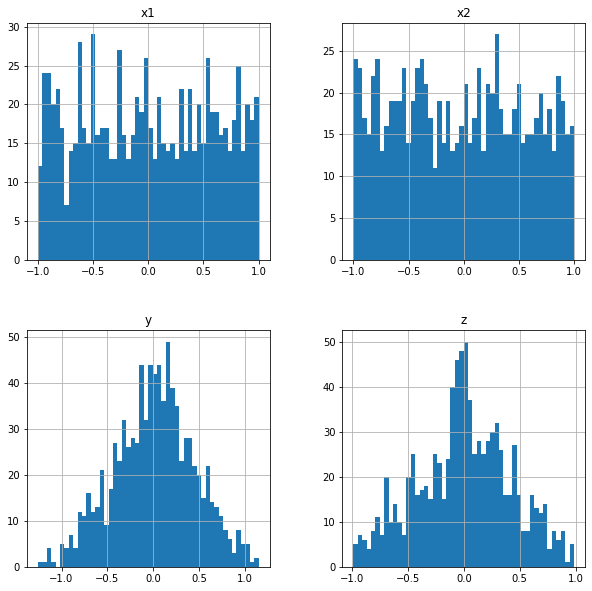

In [7]:
# histograms for each of x1, x2, y, and z
non_test_data.assign(z = compute_z(non_test_data)).hist(figsize=(10,10), bins=50)

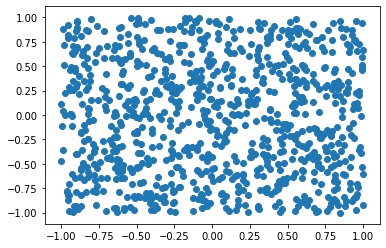

In [8]:
# (x1, x2) scatter plot
plt.scatter(non_test_data["x1"], non_test_data["x2"])

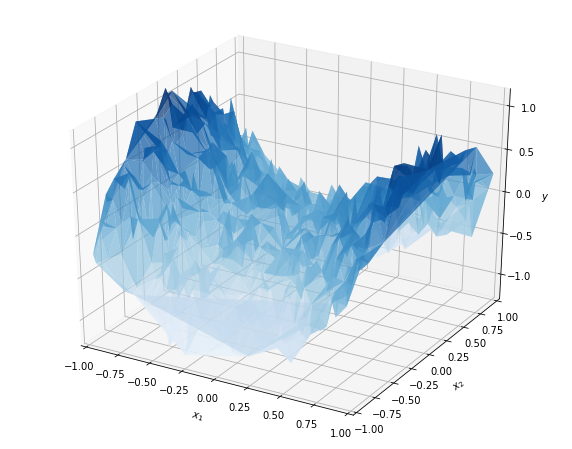

In [9]:
# (x1, x2, y) surface plot
surface = surface_plot(non_test_data["x1"], non_test_data["x2"], non_test_data["y"])

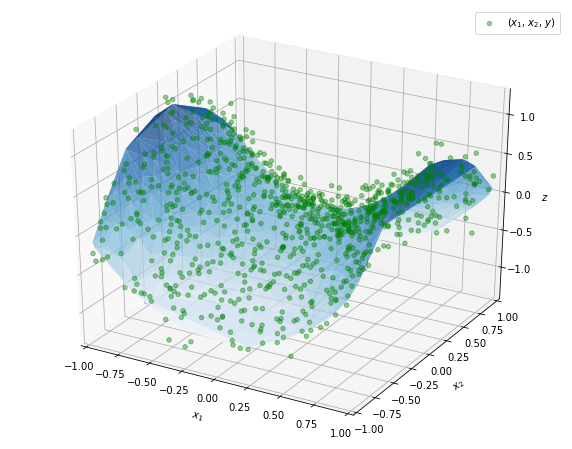

In [10]:
# (x1, x2, z) surface plot with (x1, x2, y) scatterplot overlaid
surface = surface_plot(non_test_data["x1"], non_test_data["x2"], compute_z(non_test_data), zlabel="\n$z$")
surface.scatter(non_test_data["x1"], non_test_data["x2"], non_test_data["y"], label="($x_1$, $x_2$, $y$)", c="g", alpha=0.4)
surface.legend()

The histograms show that $x_1$ and $x_2$ are relatively uniformly-distributed over $[-1, 1]$. The uneven numbers of occurrences seem to indicate that all of the $x_1$ and $x_2$ values were randomly-sampled from the previously-mentioned range.

The computed values of $z$ are normally-distributed over $[-1, 1]$. The $y$-values, which are simply the $z$-values with noise added, are also normally-distributed around $0$, but the random noise contributes to values outside $[-1, 1]$. Otherwise, the two histograms are fairly similar.

The 2D scatterplot confirms that all of the $(x_1, x_2)$ points are randomly-sampled from a $2\times 2$ area over $[-1,1]$ in both directions.

The surface plot of $x_1$ vs. $x_2$ vs. $y$ exemplifies the random noise in $y$. Specifically, the surface has many sharp peaks and valleys, but it still has a definite saddle shape.

The surface plot of $x_1$ vs. $x_2$ vs. $z$ displays a smooth saddle plot, which we should expect from a noiseless dataset. To further illustrate the differences between the computed values ($z$) and the observed values ($y$), I've scattered $x_1$ vs. $x_2$ vs. $y$ on the surface plot. We can see that none of the differences are very sigificant, but we can also see that $y$ is clearly not a fantastic representation of $z$.

### 2d: Determine the raw errors from the non-test set with respect to values returned from the saddle function; display these errors using a 50-bin histogram and discuss the histogram's shape

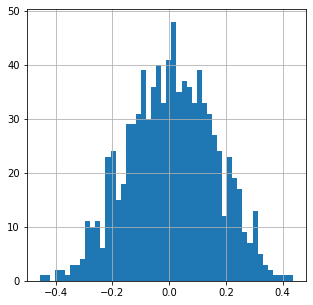

In [11]:
# compute and display the raw errors
y_diff_raw = non_test_data["y"] - compute_z(non_test_data)
y_diff_raw.hist(figsize=(5,5), bins=50)

It's clear that the errors (that is, the random noise values) are normally-distributed about $0$ in the range $[-0.45, 0.45]$ (or so). Because the actual values in $z$ are all in $[-1, 1]$, the random noise can skew the correct values by nearly $23\%$ ($\frac{0.45}{2} = 0.225$).

These errors will certainly affect the model. The model could, of course, perfectly fit the training set, but it's clear that attempts to do so would lead to overfitting. However, because these errors are normally-distributed, and because they're centered around $0$, I think the model will be able to sufficiently generalize to fit the dataset. We'll soon see if this is an accurate hypothesis.

### 2e: Display and discuss a scatterplot with the true saddle values versus raw errors

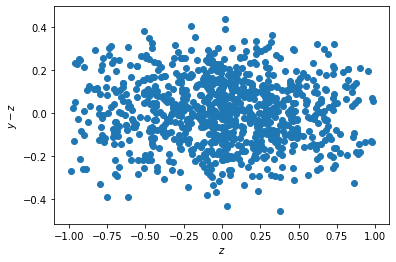

In [12]:
# scatter z vs raw errors
plt.scatter(compute_z(non_test_data), y_diff_raw)
plt.xlabel("$z$")
plt.ylabel("$y-z$")

plt.show()

This scatterplot shows that the random noise values really are random (in $[-0.45, 0.45]$). Given only $z$, it seems difficult to *guarantee* an absolute error value less than $0.45$ when predicting some $y$-value. In other words, we probably can't assure a hypothetical customer that we can get closer than $0.45$ in all cases.

Note that the scatterplot is more dense (denser?) around the center, but that has nothing to do with the random noise - it is entirely due to $z$'s distribution about $0$. Even at $z=0$, the error values are randomly distributed between $-0.45$ and $0.45$.

### 2f: Determine and report the MSE, RMSE, and mean absolute error (MAE) on the raw errors

In [13]:
print("Raw error metrics")
print("    MSE  :", np.mean(y_diff_raw ** 2))
print("    RMSE :", np.sqrt(np.mean(y_diff_raw ** 2)))
print("    MAE  :", np.mean(np.abs(y_diff_raw)))

Raw error metrics
    MSE  : 0.02363522500631578
    RMSE : 0.15373751983922396
    MAE  : 0.12465195801133513


### 3: Prepare data for training/validation

In [14]:
# split all data into input/output arrays
non_test_x = non_test_data.drop(columns=["y"])
non_test_y = non_test_data["y"]

test_x = test_data.drop(columns=["y"])
test_y = test_data["y"]

In [15]:
# split the non-test data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(non_test_x, non_test_y, test_size=0.2, random_state=42)

### 4: Build a function which accepts hyper-parameter configurations and returns a (compiled but untrained) Keras model

The instructions say that the activation function can be different for each layer. I don't yet know enough about neural networks to determine when we should use different activation functions in different layers. For this reason, I'm going to use the same activation function for every hidden layer (of course, the user can determine *which* activation function they would like to utilize).

Additionally, I'm only going to use the adam optimizer. Step 4 indicates that the function below should allow for optimizer input from the user, but Step 5 says we should have at least two options for "optimizer & learning rate" (note that the instructions combine the two hyperparameters). Because the learning rate is typically the most important hyperparameter, I'll tune the learning rate and use just the one optimizer.

In [16]:
def build_model(hidden_layers, hidden_layer_width, activation, learning_rate):
    """
    If we assume that I'm the only user here, then input verification is unnecessary. However , if I were
    defining this function for some other user, I would verify that num_hidden_layers == len(num_nodes_per_layer), 
    which in turn should equal len(activations_per_layer). I could also provide some sort of catch-all,
    where a user could enter (say) "sigmoid" for the activation and it would apply to all layers.
    
    To keep this function simple, I'm going to assume the user (see: David Crow) knows what they're doing.
    """
    
    model = Sequential()
    
    # build the first hidden layer
    # (the first hidden layer receives input from a 2-node input layer)
    model.add(Dense(
        units = hidden_layer_width,
        input_dim = 2,
        activation = activation,
        use_bias = True,
        bias_initializer = initializers.Constant(0.1) if activation == "relu" else "zeros"
    ))
    
    # build the remaining hidden layers
    for i in range(hidden_layers - 1):
        model.add(Dense(
            units = hidden_layer_width, 
            activation = activation, 
            use_bias = True, 
            bias_initializer = initializers.Constant(0.1) if activation == "relu" else "zeros"
        ))
    
    # build the output layer
    model.add(Dense(
        units = 1, 
        activation = "linear", 
        use_bias = True, 
        bias_initializer = "zeros"
    ))
    
    # compile and return the model
    model.compile(
        optimizer = optimizers.Adam(lr=learning_rate),
        loss = losses.mean_squared_error,
        metrics=[metrics.mae]
    )
    
    return model

### 5: Define configurations for multi-layer ANNs and detail your rationale

In [21]:
num_hidden_layers = [1, 2, 3, 4]
hidden_layer_widths = [1, 2, 4, 8]
activation_functions = ["hard_sigmoid", "relu"]
learning_rates = [0.1, 0.01, 0.001, 0.0001]

I want to make sure that the model doesn't learn too quickly, but I don't know how quickly is *too* quickly for neural networks, so I'll use learning rates from a wide range.

ReLU is one of the most often-used activation functions, so I definitely think I should try it here. I'm also going to test hard sigmoid because it's similar to sigmoid, but it's much faster to compute (because it abstracts away the curves).

The effects of the number of hidden layers and of the width of each layer are much more difficult for me to discern. I don't know when we should use wide layers, and I don't know what constitutes a wide layer. I also don't know how many hidden layers we should use in a given network. ~~Thus, I'm going to test a few different values from a wide range. It's certainly possible that the optimal parameters lie within these ranges but at different points (e.g., $20$), but, without testing every possible value, I don't know how I could predict that.~~ After speaking with Dr. Borghetti, I decided to test smaller networks. I still don't know the optimal values, so I'm still testing over a range -- this is just a much smaller range than before.

Finally, I don't know when the width/activation function should change from one layer to the next. For this reason, my hidden layers are all the same width, and they all use the same activation function (for a given configuration).

I could potentially test a few more parameter settings, but I'm already looking at $128$ different configurations. I'll just settle for these values.

### 6: Using the training set, train the model on each configuration developed in Step 5

In [22]:
# let's use a helper function from Homework 1
def graph_history(history):
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    
    plt.title('Model Loss ')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Tr. Loss', 'Val. Loss'])
    
    plt.show()

### 6a: Train the model in the validation loop

#1/128	MSE: 0.2010698765516281  MAE: 0.3546031713485718  Params: [1, 1, 'hard_sigmoid', 0.1]


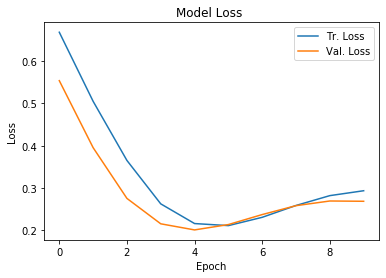

#2/128	MSE: 0.18451879918575287  MAE: 0.34182626008987427  Params: [1, 1, 'hard_sigmoid', 0.01]


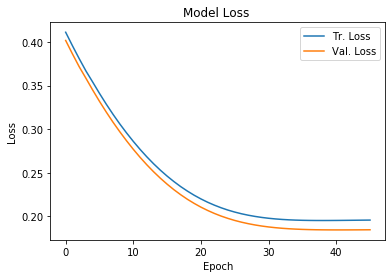

#3/128	MSE: 0.4749906361103058  MAE: 0.5869821906089783  Params: [1, 1, 'hard_sigmoid', 0.001]


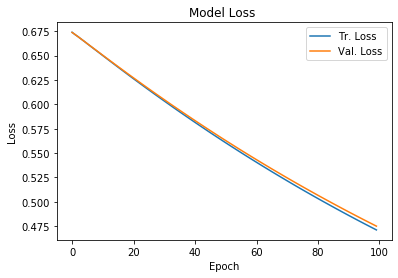

#4/128	MSE: 0.2919121980667114  MAE: 0.4431582987308502  Params: [1, 1, 'hard_sigmoid', 0.0001]


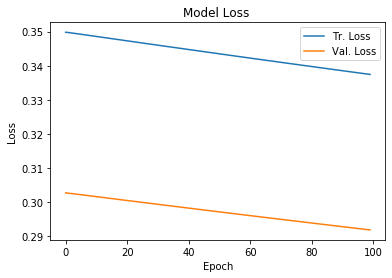

#5/128	MSE: 0.16244782507419586  MAE: 0.332476943731308  Params: [1, 1, 'relu', 0.1]


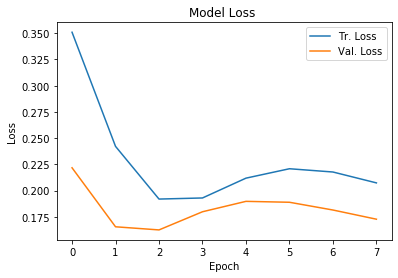

#6/128	MSE: 0.16938985884189606  MAE: 0.31971898674964905  Params: [1, 1, 'relu', 0.01]


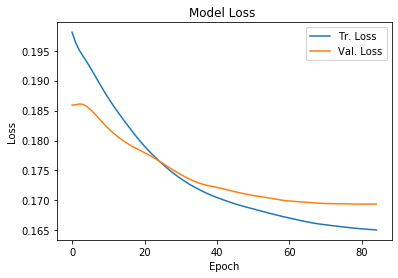

#7/128	MSE: 0.1967753767967224  MAE: 0.35074853897094727  Params: [1, 1, 'relu', 0.001]


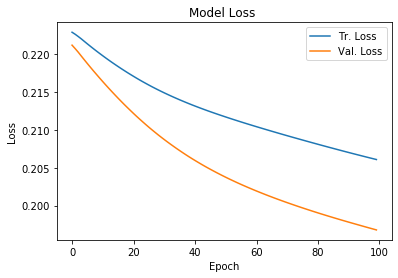

#8/128	MSE: 1.4757351875305176  MAE: 0.8326470851898193  Params: [1, 1, 'relu', 0.0001]


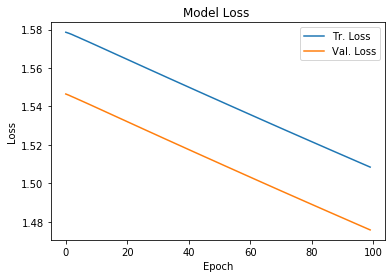

#9/128	MSE: 0.1898723989725113  MAE: 0.3441062569618225  Params: [1, 2, 'hard_sigmoid', 0.1]


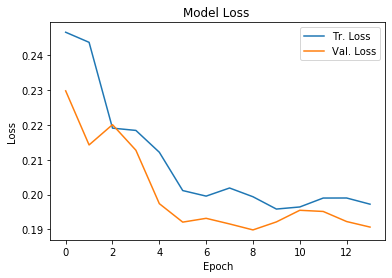

#10/128	MSE: 0.18791034817695618  MAE: 0.343302845954895  Params: [1, 2, 'hard_sigmoid', 0.01]


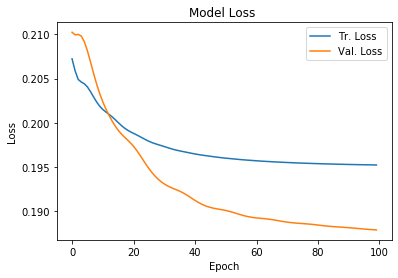

#11/128	MSE: 0.9815167188644409  MAE: 0.8875930905342102  Params: [1, 2, 'hard_sigmoid', 0.001]


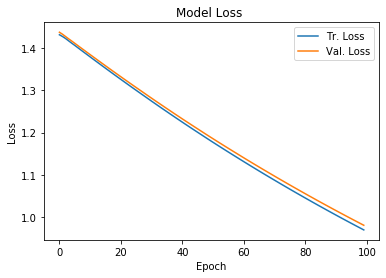

#12/128	MSE: 0.5543985366821289  MAE: 0.6381157636642456  Params: [1, 2, 'hard_sigmoid', 0.0001]


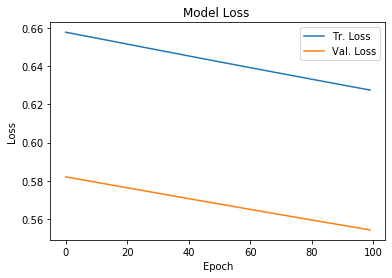

#13/128	MSE: 0.1674479991197586  MAE: 0.31973257660865784  Params: [1, 2, 'relu', 0.1]


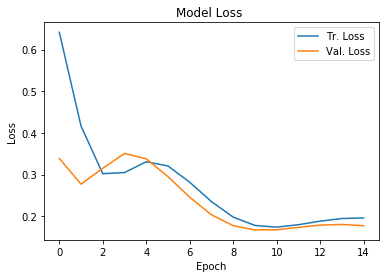

#14/128	MSE: 0.1470070630311966  MAE: 0.2884729206562042  Params: [1, 2, 'relu', 0.01]


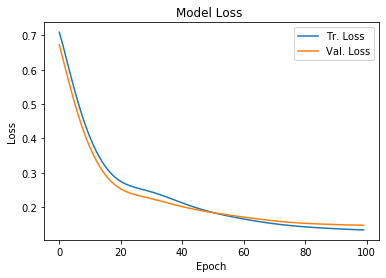

#15/128	MSE: 0.8501712083816528  MAE: 0.7105222344398499  Params: [1, 2, 'relu', 0.001]


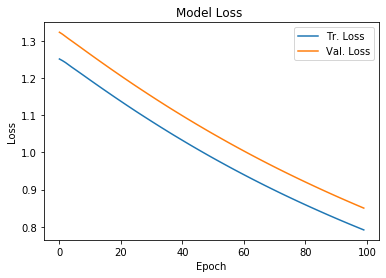

#16/128	MSE: 0.38503649830818176  MAE: 0.47554194927215576  Params: [1, 2, 'relu', 0.0001]


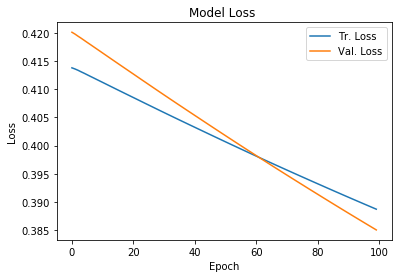

#17/128	MSE: 0.2071978747844696  MAE: 0.3606511056423187  Params: [1, 4, 'hard_sigmoid', 0.1]


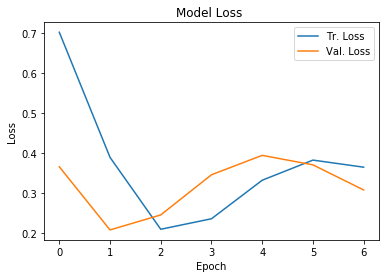

#18/128	MSE: 0.19420629739761353  MAE: 0.346457839012146  Params: [1, 4, 'hard_sigmoid', 0.01]


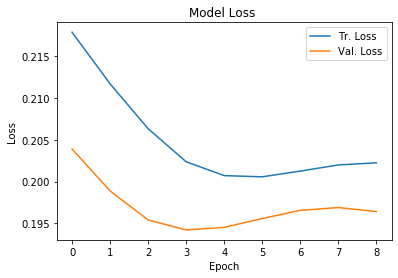

#19/128	MSE: 0.28223708271980286  MAE: 0.4240719676017761  Params: [1, 4, 'hard_sigmoid', 0.001]


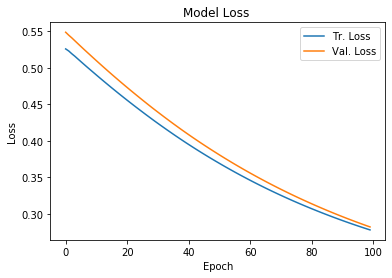

#20/128	MSE: 0.18437334895133972  MAE: 0.34195804595947266  Params: [1, 4, 'hard_sigmoid', 0.0001]


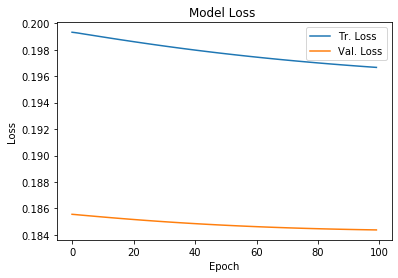

#21/128	MSE: 0.04155055060982704  MAE: 0.16010640561580658  Params: [1, 4, 'relu', 0.1]


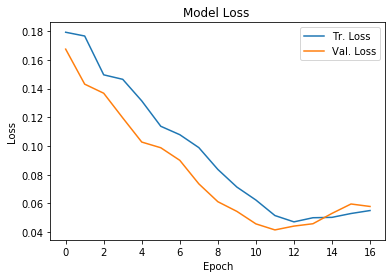

#22/128	MSE: 0.06706677377223969  MAE: 0.2017831653356552  Params: [1, 4, 'relu', 0.01]


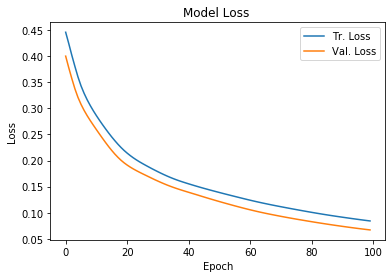

#23/128	MSE: 0.1366569697856903  MAE: 0.2907828986644745  Params: [1, 4, 'relu', 0.001]


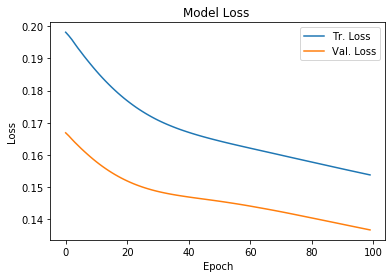

#24/128	MSE: 0.3089177906513214  MAE: 0.4412326514720917  Params: [1, 4, 'relu', 0.0001]


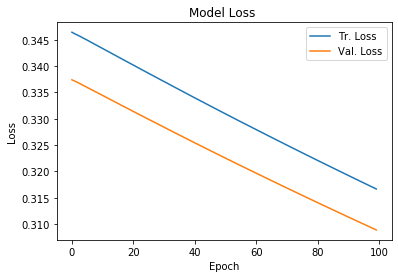

#25/128	MSE: 0.19175533950328827  MAE: 0.35392218828201294  Params: [1, 8, 'hard_sigmoid', 0.1]


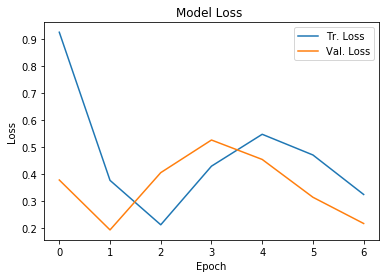

#26/128	MSE: 0.18850933015346527  MAE: 0.34368836879730225  Params: [1, 8, 'hard_sigmoid', 0.01]


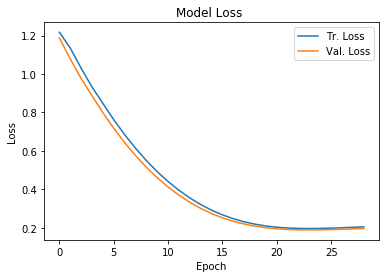

#27/128	MSE: 0.3129239082336426  MAE: 0.46500658988952637  Params: [1, 8, 'hard_sigmoid', 0.001]


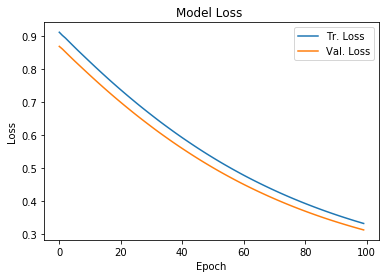

#28/128	MSE: 0.19453637301921844  MAE: 0.3459151089191437  Params: [1, 8, 'hard_sigmoid', 0.0001]


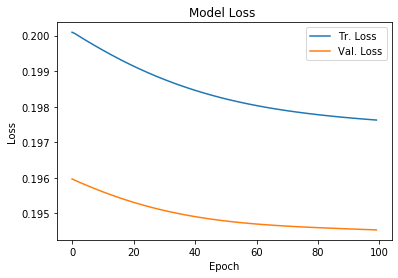

#29/128	MSE: 0.03397369012236595  MAE: 0.1508122980594635  Params: [1, 8, 'relu', 0.1]


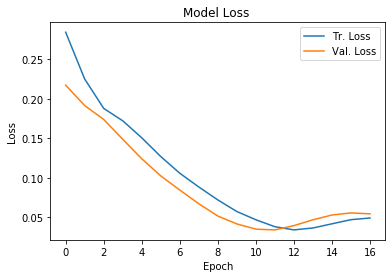

#30/128	MSE: 0.03370596095919609  MAE: 0.15325191617012024  Params: [1, 8, 'relu', 0.01]


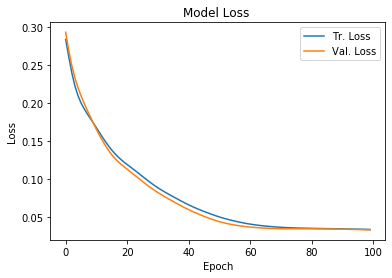

#31/128	MSE: 0.17763999104499817  MAE: 0.32578471302986145  Params: [1, 8, 'relu', 0.001]


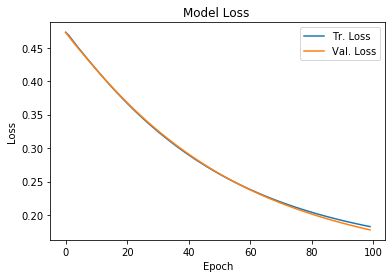

#32/128	MSE: 0.16853412985801697  MAE: 0.32299187779426575  Params: [1, 8, 'relu', 0.0001]


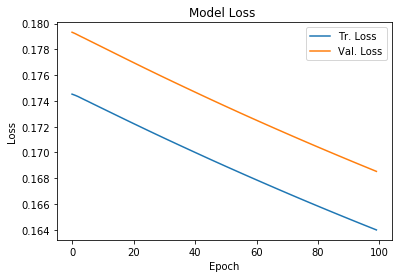

#33/128	MSE: 0.18533562123775482  MAE: 0.34232664108276367  Params: [2, 1, 'hard_sigmoid', 0.1]


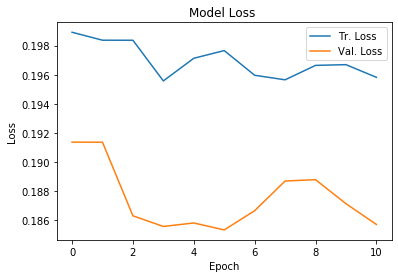

#34/128	MSE: 0.1857237070798874  MAE: 0.34268948435783386  Params: [2, 1, 'hard_sigmoid', 0.01]


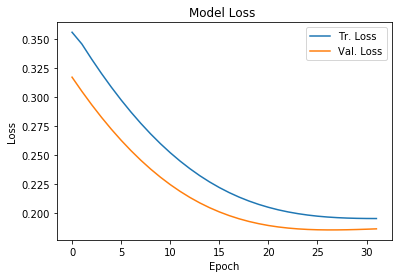

#35/128	MSE: 0.39863306283950806  MAE: 0.5219696760177612  Params: [2, 1, 'hard_sigmoid', 0.001]


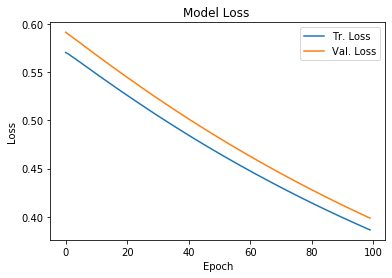

#36/128	MSE: 1.2261422872543335  MAE: 1.0204404592514038  Params: [2, 1, 'hard_sigmoid', 0.0001]


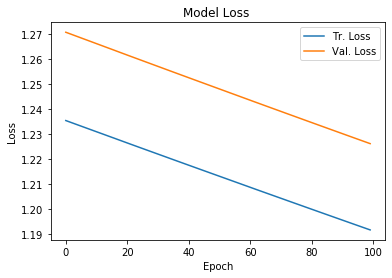

#37/128	MSE: 0.15106460452079773  MAE: 0.31002435088157654  Params: [2, 1, 'relu', 0.1]


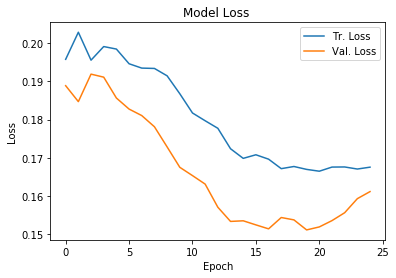

#38/128	MSE: 0.18609625101089478  MAE: 0.3450864255428314  Params: [2, 1, 'relu', 0.01]


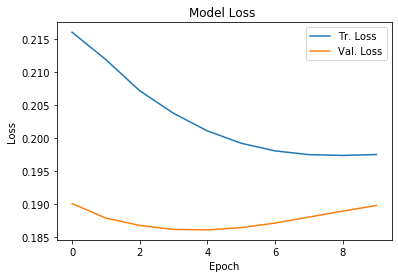

#39/128	MSE: 0.1904960572719574  MAE: 0.34405001997947693  Params: [2, 1, 'relu', 0.001]


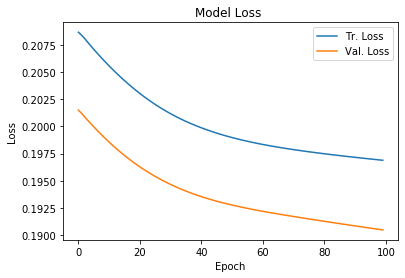

#40/128	MSE: 0.1855267435312271  MAE: 0.34654125571250916  Params: [2, 1, 'relu', 0.0001]


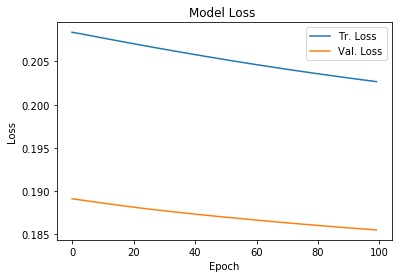

#41/128	MSE: 0.18386167287826538  MAE: 0.3417041003704071  Params: [2, 2, 'hard_sigmoid', 0.1]


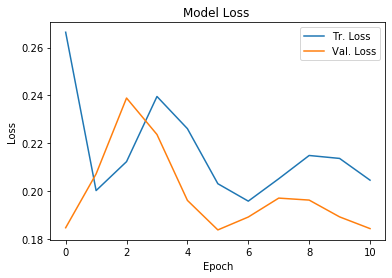

#42/128	MSE: 0.18656519055366516  MAE: 0.34265872836112976  Params: [2, 2, 'hard_sigmoid', 0.01]


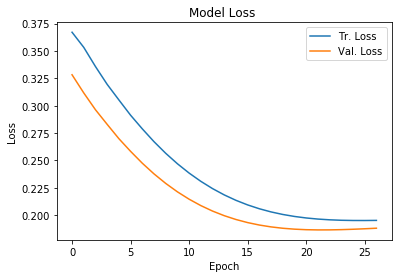

#43/128	MSE: 0.6796875596046448  MAE: 0.7236721515655518  Params: [2, 2, 'hard_sigmoid', 0.001]


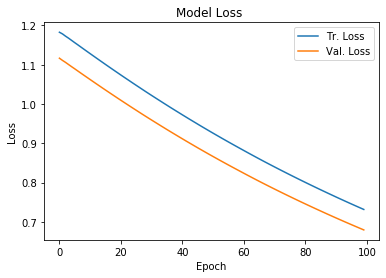

#44/128	MSE: 1.1498650312423706  MAE: 0.9855886101722717  Params: [2, 2, 'hard_sigmoid', 0.0001]


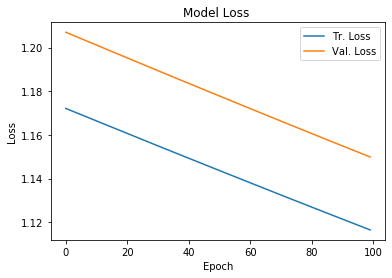

#45/128	MSE: 0.17661641538143158  MAE: 0.34479379653930664  Params: [2, 2, 'relu', 0.1]


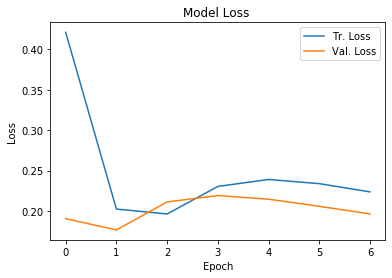

#46/128	MSE: 0.10157059878110886  MAE: 0.2574211061000824  Params: [2, 2, 'relu', 0.01]


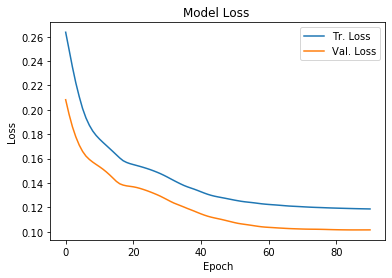

#47/128	MSE: 0.28751954436302185  MAE: 0.3984217345714569  Params: [2, 2, 'relu', 0.001]


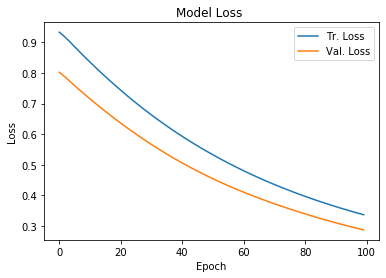

#48/128	MSE: 0.3974188566207886  MAE: 0.4742157757282257  Params: [2, 2, 'relu', 0.0001]


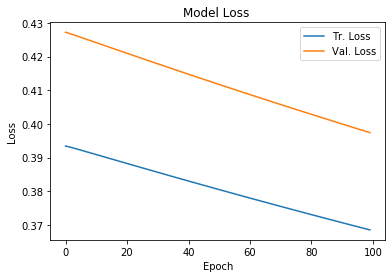

#49/128	MSE: 0.1860334575176239  MAE: 0.34247300028800964  Params: [2, 4, 'hard_sigmoid', 0.1]


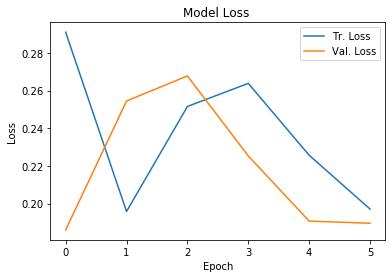

#50/128	MSE: 0.1842716634273529  MAE: 0.34200194478034973  Params: [2, 4, 'hard_sigmoid', 0.01]


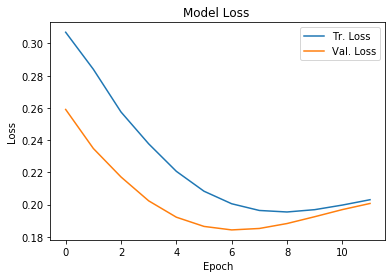

#51/128	MSE: 0.18932121992111206  MAE: 0.34717893600463867  Params: [2, 4, 'hard_sigmoid', 0.001]


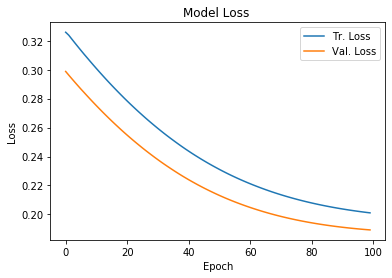

#52/128	MSE: 0.21307657659053802  MAE: 0.36501821875572205  Params: [2, 4, 'hard_sigmoid', 0.0001]


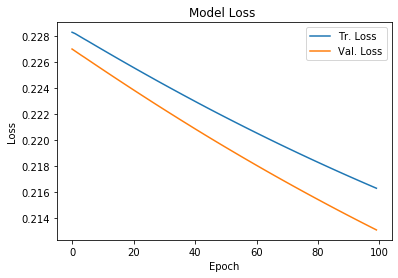

#53/128	MSE: 0.18373961746692657  MAE: 0.34081903100013733  Params: [2, 4, 'relu', 0.1]


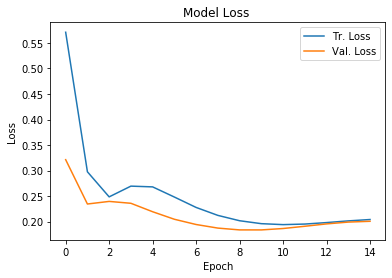

#54/128	MSE: 0.11923333257436752  MAE: 0.25819820165634155  Params: [2, 4, 'relu', 0.01]


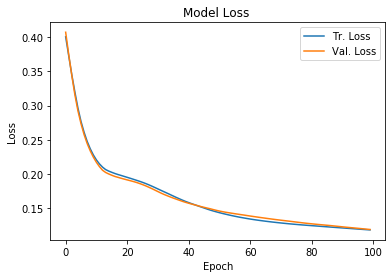

#55/128	MSE: 0.17519605159759521  MAE: 0.32901129126548767  Params: [2, 4, 'relu', 0.001]


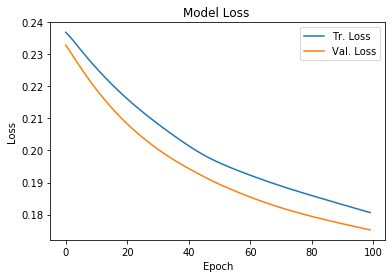

#56/128	MSE: 0.18181359767913818  MAE: 0.3424087166786194  Params: [2, 4, 'relu', 0.0001]


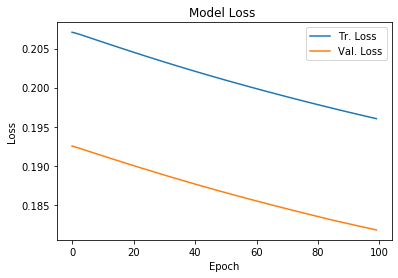

#57/128	MSE: 0.18799667060375214  MAE: 0.344967246055603  Params: [2, 8, 'hard_sigmoid', 0.1]


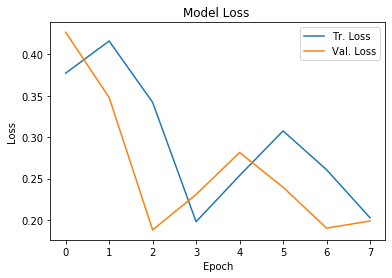

#58/128	MSE: 0.1877894252538681  MAE: 0.3433712422847748  Params: [2, 8, 'hard_sigmoid', 0.01]


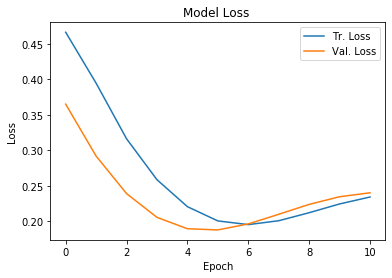

#59/128	MSE: 0.31372249126434326  MAE: 0.46183061599731445  Params: [2, 8, 'hard_sigmoid', 0.001]


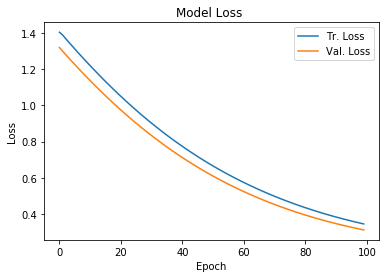

#60/128	MSE: 0.18394175171852112  MAE: 0.3419327735900879  Params: [2, 8, 'hard_sigmoid', 0.0001]


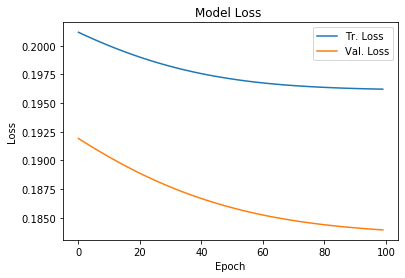

#61/128	MSE: 0.03199627250432968  MAE: 0.14901138842105865  Params: [2, 8, 'relu', 0.1]


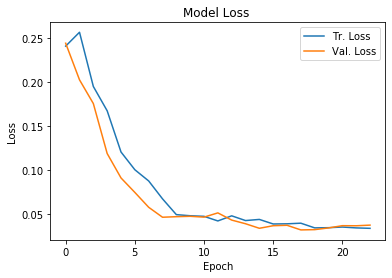

#62/128	MSE: 0.03974444419145584  MAE: 0.16436296701431274  Params: [2, 8, 'relu', 0.01]


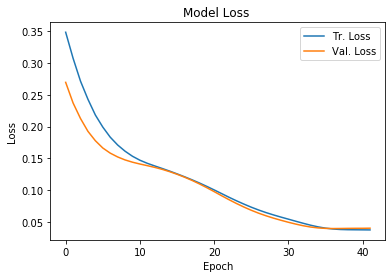

#63/128	MSE: 0.08735973387956619  MAE: 0.23227807879447937  Params: [2, 8, 'relu', 0.001]


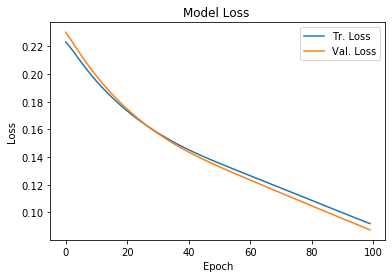

#64/128	MSE: 0.15965524315834045  MAE: 0.3272007703781128  Params: [2, 8, 'relu', 0.0001]


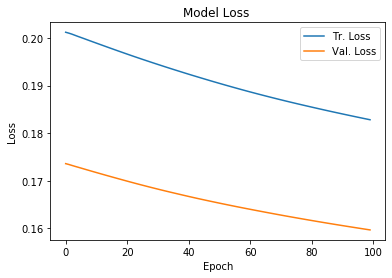

#65/128	MSE: 0.18573646247386932  MAE: 0.3437040150165558  Params: [3, 1, 'hard_sigmoid', 0.1]


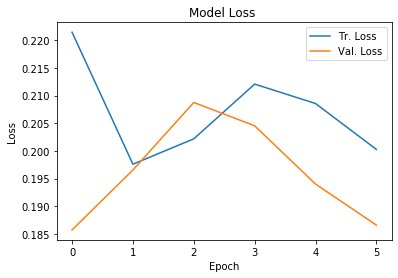

#66/128	MSE: 0.1854371428489685  MAE: 0.34237048029899597  Params: [3, 1, 'hard_sigmoid', 0.01]


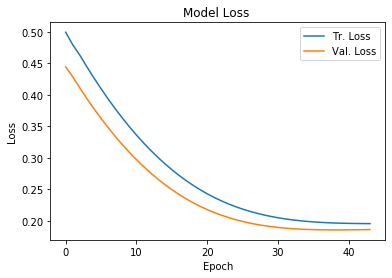

#67/128	MSE: 0.44594234228134155  MAE: 0.5641714334487915  Params: [3, 1, 'hard_sigmoid', 0.001]


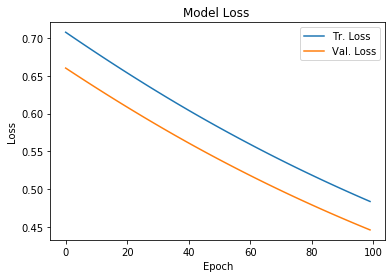

#68/128	MSE: 0.24719861149787903  MAE: 0.4088466167449951  Params: [3, 1, 'hard_sigmoid', 0.0001]


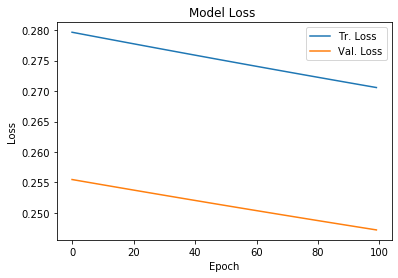

#69/128	MSE: 0.18533755838871002  MAE: 0.34233859181404114  Params: [3, 1, 'relu', 0.1]


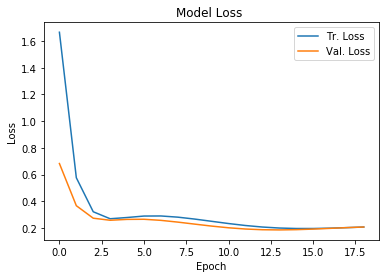

#70/128	MSE: 0.18379107117652893  MAE: 0.34167927503585815  Params: [3, 1, 'relu', 0.01]


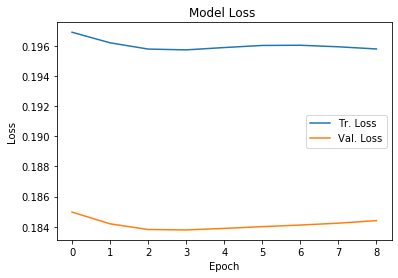

#71/128	MSE: 0.17594566941261292  MAE: 0.33467772603034973  Params: [3, 1, 'relu', 0.001]


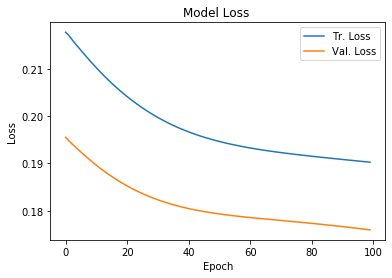

#72/128	MSE: 0.19058728218078613  MAE: 0.34606871008872986  Params: [3, 1, 'relu', 0.0001]


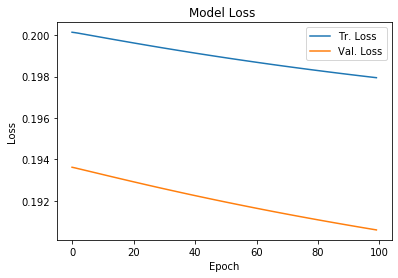

#73/128	MSE: 0.1856326460838318  MAE: 0.3423351049423218  Params: [3, 2, 'hard_sigmoid', 0.1]


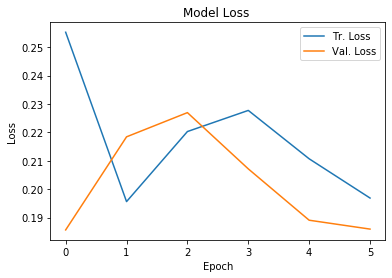

#74/128	MSE: 0.1854752004146576  MAE: 0.342264324426651  Params: [3, 2, 'hard_sigmoid', 0.01]


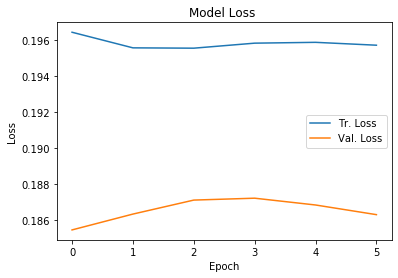

#75/128	MSE: 0.2453746199607849  MAE: 0.4073246717453003  Params: [3, 2, 'hard_sigmoid', 0.001]


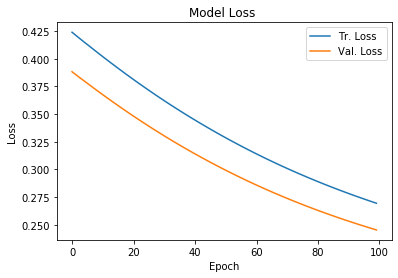

#76/128	MSE: 0.2333334982395172  MAE: 0.38265788555145264  Params: [3, 2, 'hard_sigmoid', 0.0001]


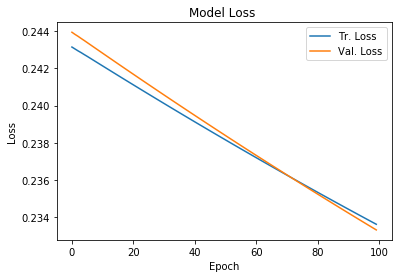

#77/128	MSE: 0.1101398691534996  MAE: 0.24892295897006989  Params: [3, 2, 'relu', 0.1]


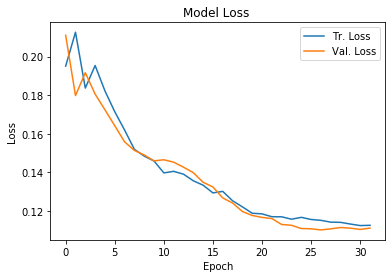

#78/128	MSE: 0.17045381665229797  MAE: 0.3279452323913574  Params: [3, 2, 'relu', 0.01]


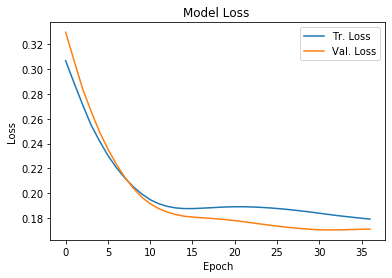

#79/128	MSE: 0.18647882342338562  MAE: 0.34293001890182495  Params: [3, 2, 'relu', 0.001]


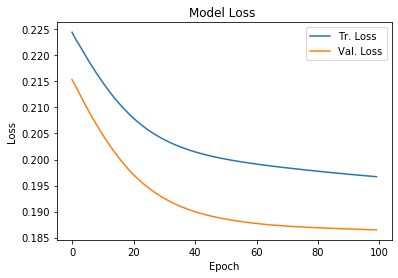

#80/128	MSE: 1.076550006866455  MAE: 0.7469277381896973  Params: [3, 2, 'relu', 0.0001]


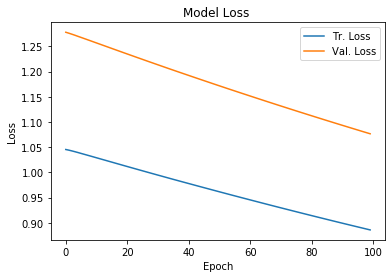

#81/128	MSE: 0.18527546525001526  MAE: 0.3421408236026764  Params: [3, 4, 'hard_sigmoid', 0.1]


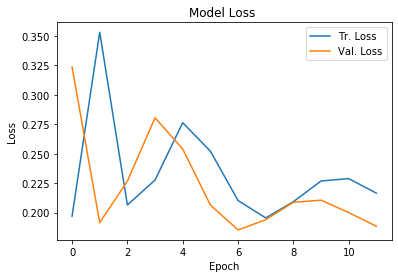

#82/128	MSE: 0.18464890122413635  MAE: 0.34218302369117737  Params: [3, 4, 'hard_sigmoid', 0.01]


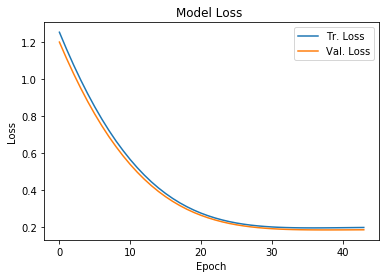

#83/128	MSE: 0.21703028678894043  MAE: 0.36801356077194214  Params: [3, 4, 'hard_sigmoid', 0.001]


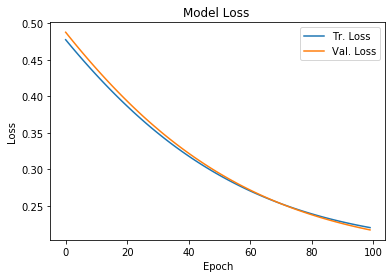

#84/128	MSE: 0.5400489568710327  MAE: 0.6244627237319946  Params: [3, 4, 'hard_sigmoid', 0.0001]


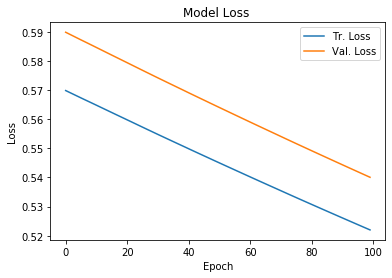

#85/128	MSE: 0.18332019448280334  MAE: 0.3410147726535797  Params: [3, 4, 'relu', 0.1]


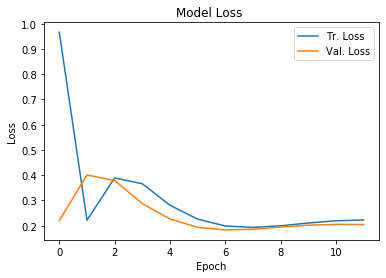

#86/128	MSE: 0.03936852514743805  MAE: 0.16342587769031525  Params: [3, 4, 'relu', 0.01]


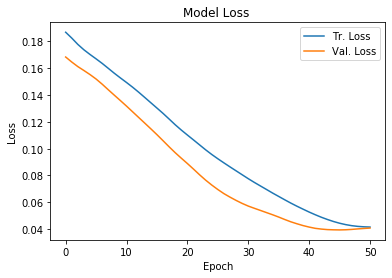

#87/128	MSE: 0.13463157415390015  MAE: 0.2906404137611389  Params: [3, 4, 'relu', 0.001]


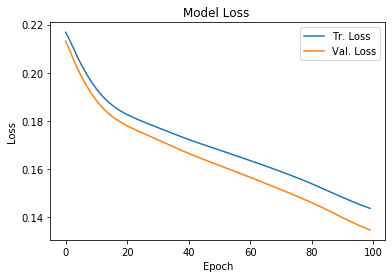

#88/128	MSE: 0.21525472402572632  MAE: 0.36777105927467346  Params: [3, 4, 'relu', 0.0001]


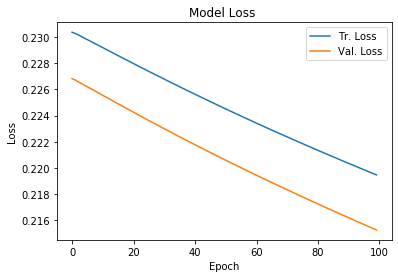

#89/128	MSE: 0.18848589062690735  MAE: 0.3442792296409607  Params: [3, 8, 'hard_sigmoid', 0.1]


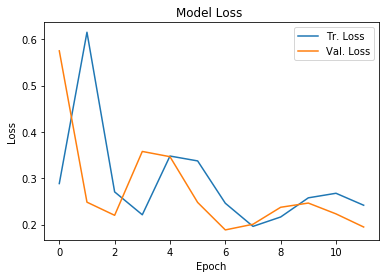

#90/128	MSE: 0.18539708852767944  MAE: 0.34235498309135437  Params: [3, 8, 'hard_sigmoid', 0.01]


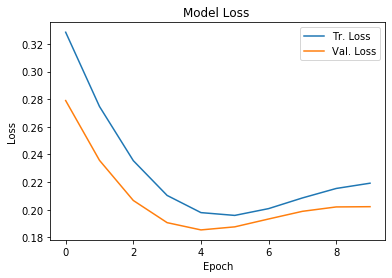

#91/128	MSE: 0.18536019325256348  MAE: 0.34267672896385193  Params: [3, 8, 'hard_sigmoid', 0.001]


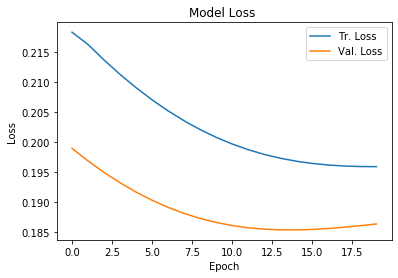

#92/128	MSE: 1.1664471626281738  MAE: 0.9918729066848755  Params: [3, 8, 'hard_sigmoid', 0.0001]


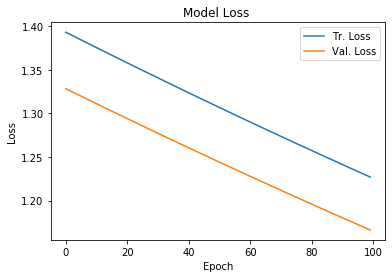

#93/128	MSE: 0.1907498687505722  MAE: 0.34610044956207275  Params: [3, 8, 'relu', 0.1]


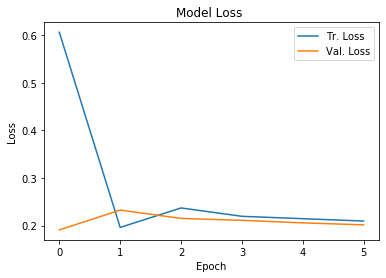

#94/128	MSE: 0.055507592856884  MAE: 0.18829798698425293  Params: [3, 8, 'relu', 0.01]


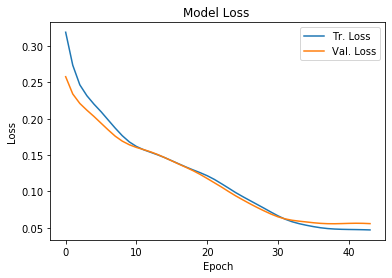

#95/128	MSE: 0.09643058478832245  MAE: 0.23607127368450165  Params: [3, 8, 'relu', 0.001]


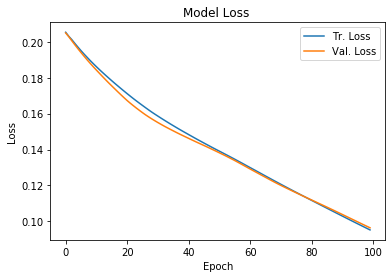

#96/128	MSE: 0.3312775194644928  MAE: 0.44820064306259155  Params: [3, 8, 'relu', 0.0001]


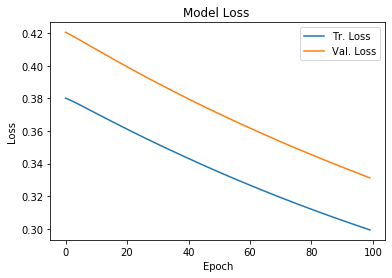

#97/128	MSE: 0.18745116889476776  MAE: 0.34602850675582886  Params: [4, 1, 'hard_sigmoid', 0.1]


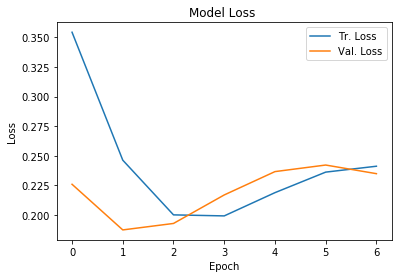

#98/128	MSE: 0.18533460795879364  MAE: 0.342543363571167  Params: [4, 1, 'hard_sigmoid', 0.01]


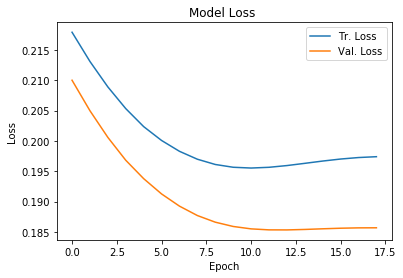

#99/128	MSE: 0.1853605955839157  MAE: 0.3424544334411621  Params: [4, 1, 'hard_sigmoid', 0.001]


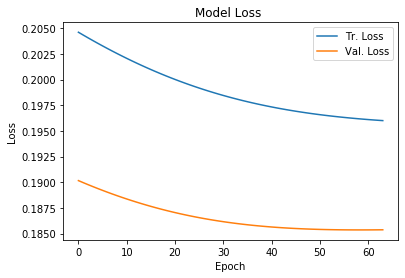

#100/128	MSE: 0.18784531950950623  MAE: 0.34398648142814636  Params: [4, 1, 'hard_sigmoid', 0.0001]


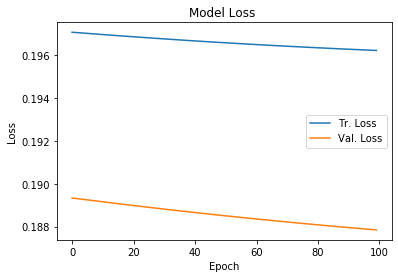

#101/128	MSE: 0.18459650874137878  MAE: 0.34136664867401123  Params: [4, 1, 'relu', 0.1]


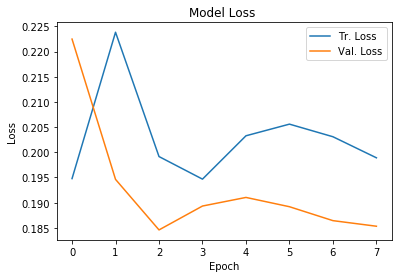

#102/128	MSE: 0.18536792695522308  MAE: 0.3427153527736664  Params: [4, 1, 'relu', 0.01]


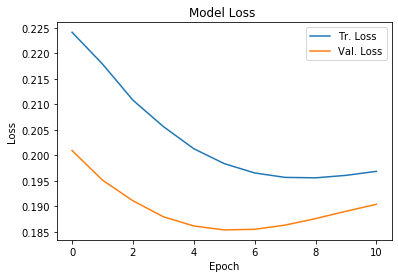

#103/128	MSE: 0.184675931930542  MAE: 0.34302207827568054  Params: [4, 1, 'relu', 0.001]


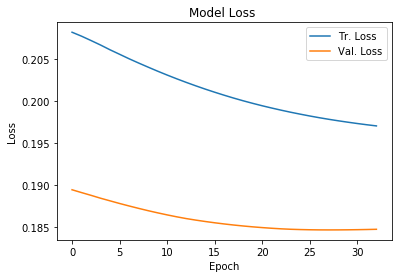

#104/128	MSE: 0.18442294001579285  MAE: 0.3414224088191986  Params: [4, 1, 'relu', 0.0001]


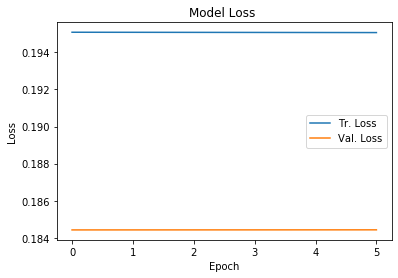

#105/128	MSE: 0.1855209618806839  MAE: 0.34229400753974915  Params: [4, 2, 'hard_sigmoid', 0.1]


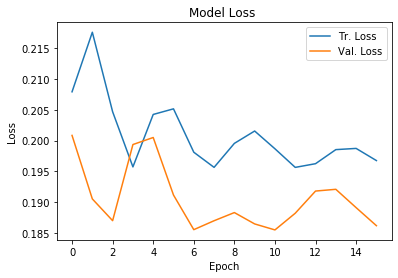

#106/128	MSE: 0.18533529341220856  MAE: 0.3425273895263672  Params: [4, 2, 'hard_sigmoid', 0.01]


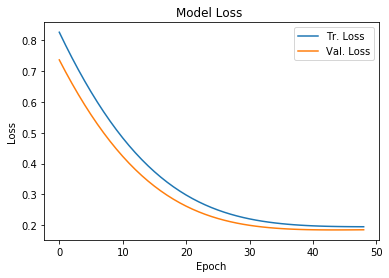

#107/128	MSE: 0.18554839491844177  MAE: 0.3432638943195343  Params: [4, 2, 'hard_sigmoid', 0.001]


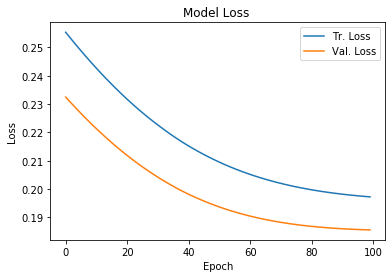

#108/128	MSE: 0.18557722866535187  MAE: 0.34330904483795166  Params: [4, 2, 'hard_sigmoid', 0.0001]


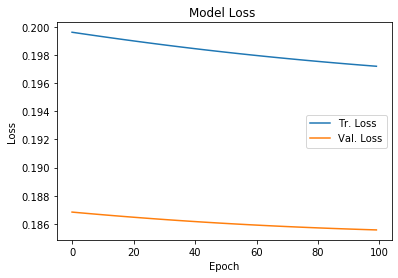

#109/128	MSE: 0.17934368550777435  MAE: 0.34061330556869507  Params: [4, 2, 'relu', 0.1]


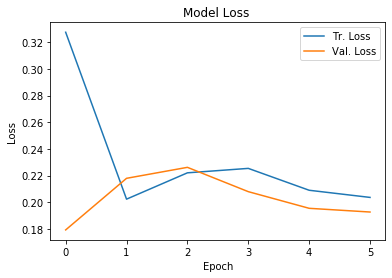

#110/128	MSE: 0.1558915674686432  MAE: 0.30032697319984436  Params: [4, 2, 'relu', 0.01]


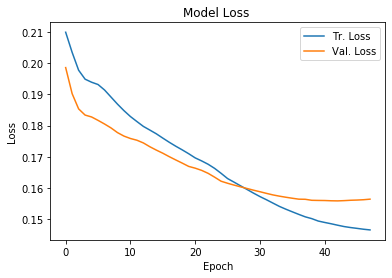

#111/128	MSE: 0.1846841424703598  MAE: 0.3419981598854065  Params: [4, 2, 'relu', 0.001]


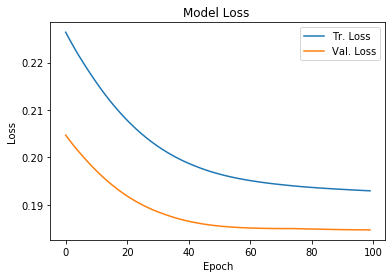

#112/128	MSE: 0.3129083812236786  MAE: 0.4554896950721741  Params: [4, 2, 'relu', 0.0001]


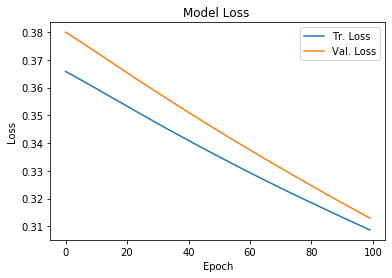

#113/128	MSE: 0.18510589003562927  MAE: 0.34282541275024414  Params: [4, 4, 'hard_sigmoid', 0.1]


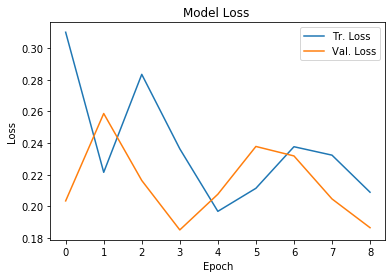

#114/128	MSE: 0.18529459834098816  MAE: 0.34256622195243835  Params: [4, 4, 'hard_sigmoid', 0.01]


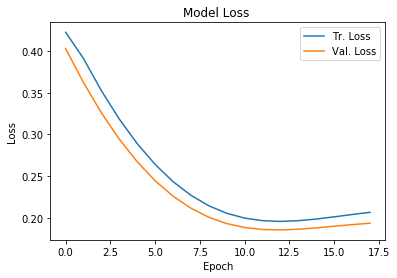

#115/128	MSE: 0.1853131651878357  MAE: 0.3424423336982727  Params: [4, 4, 'hard_sigmoid', 0.001]


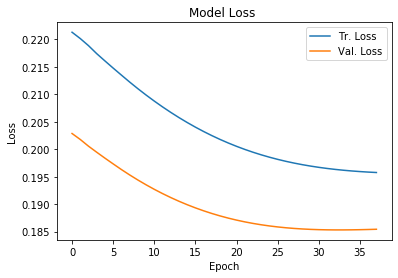

#116/128	MSE: 0.4001772105693817  MAE: 0.5237298011779785  Params: [4, 4, 'hard_sigmoid', 0.0001]


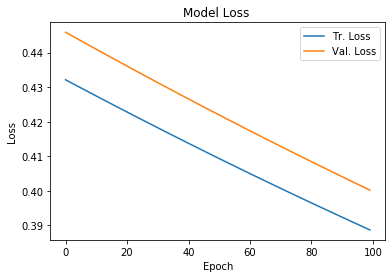

#117/128	MSE: 0.18535710871219635  MAE: 0.3426746726036072  Params: [4, 4, 'relu', 0.1]


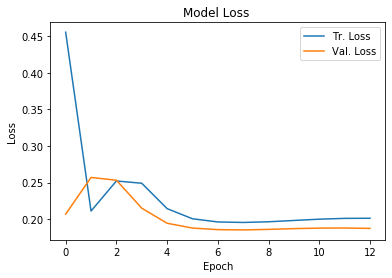

#118/128	MSE: 0.028136150911450386  MAE: 0.13791923224925995  Params: [4, 4, 'relu', 0.01]


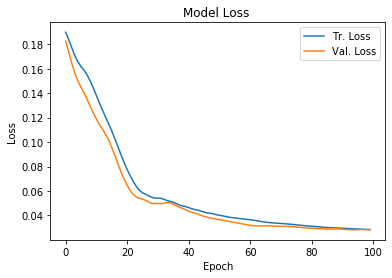

#119/128	MSE: 0.15018008649349213  MAE: 0.3106885552406311  Params: [4, 4, 'relu', 0.001]


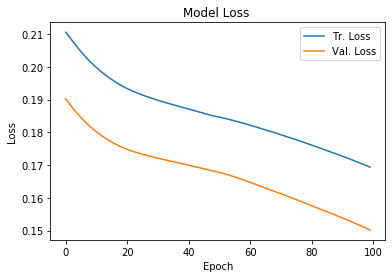

#120/128	MSE: 0.4832127094268799  MAE: 0.5533661842346191  Params: [4, 4, 'relu', 0.0001]


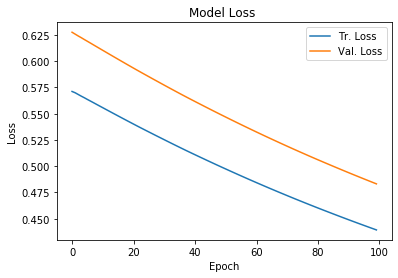

#121/128	MSE: 0.18548329174518585  MAE: 0.34228312969207764  Params: [4, 8, 'hard_sigmoid', 0.1]


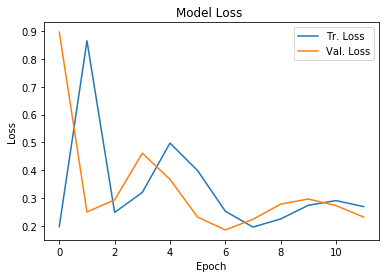

#122/128	MSE: 0.18619723618030548  MAE: 0.34266871213912964  Params: [4, 8, 'hard_sigmoid', 0.01]


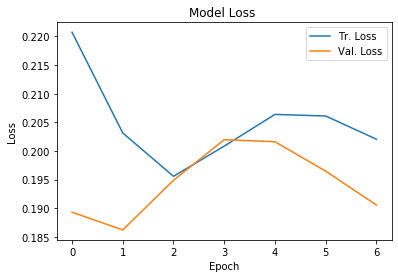

#123/128	MSE: 0.18536913394927979  MAE: 0.34255746006965637  Params: [4, 8, 'hard_sigmoid', 0.001]


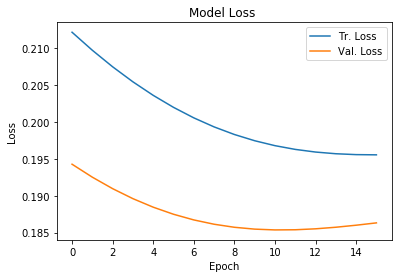

#124/128	MSE: 0.18526512384414673  MAE: 0.34240248799324036  Params: [4, 8, 'hard_sigmoid', 0.0001]


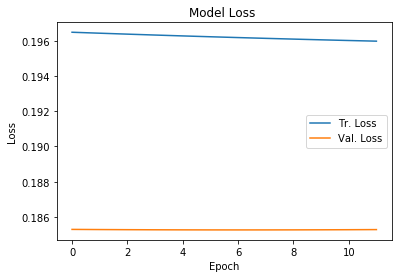

#125/128	MSE: 0.17935612797737122  MAE: 0.33832278847694397  Params: [4, 8, 'relu', 0.1]


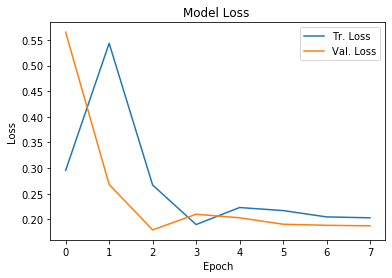

#126/128	MSE: 0.04057330638170242  MAE: 0.1575527787208557  Params: [4, 8, 'relu', 0.01]


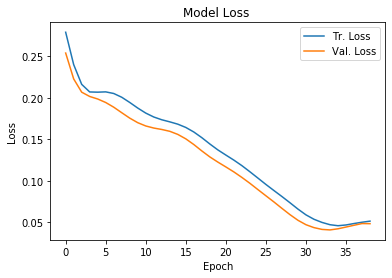

#127/128	MSE: 0.14708095788955688  MAE: 0.30221259593963623  Params: [4, 8, 'relu', 0.001]


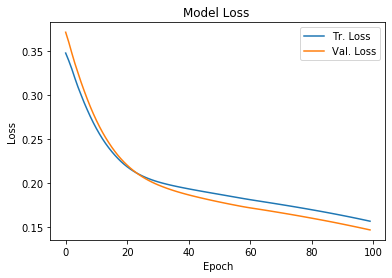

#128/128	MSE: 0.3449510335922241  MAE: 0.46416395902633667  Params: [4, 8, 'relu', 0.0001]


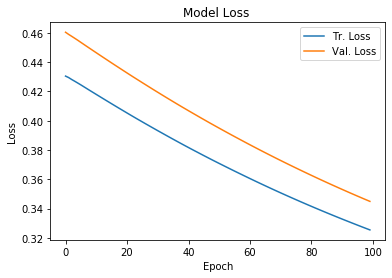

Elapsed time: 1464.2127990722656 seconds


In [23]:
# we might need these in a future step
config_mses = None
config_maes = None
config_params = None

num_configs = len(num_hidden_layers) * len(hidden_layer_widths) \
    * len(activation_functions) * len(learning_rates)

if RUN_CONFIGURATION_LOOP: 
    start = time.time()
    
    # okay, we definitely need these in a future step
    config_mses = []
    config_maes = []
    config_params = []
    
    # define an early stopping callback
    callbacks = [EarlyStopping(
        monitor='val_loss',
        patience=5, 
        restore_best_weights=True
    )]

    # just to keep an eye on progress
    counter = 1

    # loop over and train each configuration
    for n in num_hidden_layers:
        for w in hidden_layer_widths:
            for a in activation_functions:
                for l in learning_rates:
                    # build the model
                    model = build_model(n, w, a, l)

                    # train the model
                    history = model.fit(
                        x=train_x,
                        y=train_y,
                        validation_data=(val_x, val_y),
                        epochs=100,
                        batch_size=len(train_x),
                        callbacks=callbacks,
                        verbose=0,
                        shuffle=True
                    )

                    # capture and display the results
                    val_loss = model.evaluate(val_x, val_y, batch_size=len(val_x), verbose=0)
                    print("#{}/{}\tMSE: {}  MAE: {}  Params: {}".format(
                        counter, num_configs, val_loss[0], val_loss[1], [n, w, a, l]))
                    graph_history(history)
                    
                    # save the results
                    config_mses.append(val_loss[0])
                    config_maes.append(val_loss[1])
                    config_params.append([n, w, a, l])

                    counter += 1
    
    print("Elapsed time: {} seconds".format(time.time() - start))

### 6b: Report the best configuration and discuss

In [24]:
if RUN_CONFIGURATION_LOOP:
    # build a dataframe (for readability)
    results = pd.DataFrame(
        np.hstack((
            np.array(config_mses).reshape(-1,1),
            np.array(config_maes).reshape(-1,1),
            np.array([str(x) for x in config_params]).reshape(-1,1)
        )).reshape(num_configs, 3), 
        columns=["MSE", "MAE", "Parameters"]
    )
    
    # display the best configurations
    display(results.sort_values(by="MSE").reset_index().head(10))

,index,MSE,MAE,Parameters
0,117,0.028136150911450386,0.13791923224925995,"[4, 4, 'relu', 0.01]"
1,60,0.03199627250432968,0.14901138842105865,"[2, 8, 'relu', 0.1]"
2,29,0.03370596095919609,0.15325191617012024,"[1, 8, 'relu', 0.01]"
3,28,0.03397369012236595,0.1508122980594635,"[1, 8, 'relu', 0.1]"
4,85,0.03936852514743805,0.16342587769031525,"[3, 4, 'relu', 0.01]"
5,61,0.03974444419145584,0.16436296701431274,"[2, 8, 'relu', 0.01]"
6,125,0.04057330638170242,0.1575527787208557,"[4, 8, 'relu', 0.01]"
7,20,0.04155055060982704,0.16010640561580658,"[1, 4, 'relu', 0.1]"
8,93,0.055507592856884,0.18829798698425293,"[3, 8, 'relu', 0.01]"
9,21,0.06706677377223969,0.2017831653356552,"[1, 4, 'relu', 0.01]"


The single best model configuration uses four hidden layers, each with four nodes. Every hidden layer uses a ReLU activation function, and the model's learning rate is 0.01.

Patterns become evident when we examine the *10* best configurations. All of these configurations use a ReLU activation function for the hidden layers, and most of these configurations use hidden layers of eight nodes. For the saddle dataset, it's clear that wide networks typically work best, and it's also clear that ReLU outperforms hard sigmoid.

Additionally, all of the best configurations use learning rates greater than or equal to $0.01$. This illustrates that, for this dataset, the neural network must learn slowly to achieve the best possible performance but that extremely small learning rates are insufficiently slow over 100 epochs (this is entirely expected).

Properly analyzing the effect of the network's depth is more difficult. The best model configuration uses four hidden layers, but every num_hidden_layer value is represented in the Top 10. A pattern is not evident. It seems that this hyperparameter's value may lead to strong performance only when used with certain combinations of other hyperparameters. I'm not really sure, though.

It's likely the case that the best configuration outperformed the others simply because the training/validation split benefits networks of this type. Honestly, though, I'm just hypothesizing - I'm not sure why one configuration should outperform another for this dataset.

### 7: Select the best configuration from the previous step

In [25]:
hidden_layers = 4
hidden_layer_width = 4
activation = "relu"
learning_rate = 0.01

model = build_model(hidden_layers, hidden_layer_width, activation, learning_rate)

### 8: Retrain the best model

In [26]:
"""
Because we're only training one model here, we might as well see if the model
improves when given a much longer training period. For this reason, we'll
train the model with 1000 epochs and without an early stopping callback.
"""

start = time.time()

# train the model
history = model.fit(
    x = non_test_x,
    y = non_test_y,
    epochs = 1000,
    batch_size = len(non_test_x),
    verbose = 0,
    shuffle = True
)

print("Elapsed time: {} seconds".format(time.time() - start))

Elapsed time: 20.535356998443604 seconds


### 9: Determine if the model trained on all of the non-test data produces saddle-function predictions better than the non-test data y-values themselves

### 9a: Run predictions on all of the non-test data

In [27]:
# predict the non-test values
y_hat_train = model.predict(non_test_x, batch_size=len(non_test_x), verbose=0).ravel()

### 9b: Determine the prediction errors on the non-test set

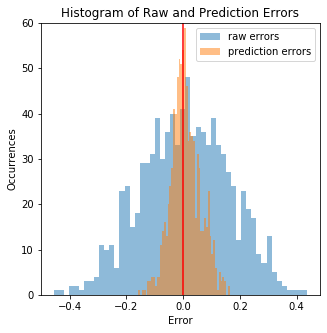

In [28]:
# compute the prediction errors
y_diff_train = y_hat_train - compute_z(non_test_x)

# create the figure
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

# pretty-fy the subplot
ax.set_xlabel("Error")
ax.set_ylabel("Occurrences")
ax.set_title("Histogram of Raw and Prediction Errors")

# plot it
ax.hist(y_diff_raw, bins=50, alpha=0.5, label="raw errors")
ax.hist(y_diff_train, bins=50, alpha=0.5, label="prediction errors")
ax.legend()

# add a vertical line at error = 0
ax.set_ylim(0, 60)
ax.plot([0, 0], [0, 60], c="r")

plt.show()

The above histograms clearly show that the model effectively predicts the $z$-values -- or, at least, that it outperforms the dataset's given $y$-values. The model's errors lie within $[-0.15, 0.15]$. Clearly, this is a much narrower range of errors than the raw $y$-values, for which the error range is $[-0.45, 0.45]$.

Additionally, the prediction errors are, for the most part, normally-distributed. Most of the errors lie within the center of the range, so most of the errors are close to zero. Clearly, the model predicts the dataset fairly well.

Note that the prediction errors are slightly skewed to the right. This means that, in cases where the model mispredicts a $z$-value, it tends to overpredict. I'm not sure why this is the case, but the skew is not very significant.

### 9c: Display and discuss a scatterplot of the true saddle values versus prediction errors

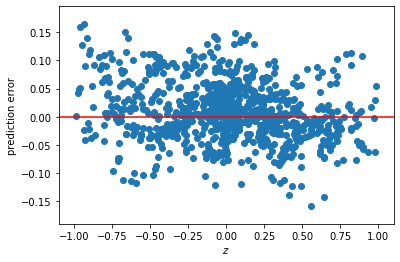

In [29]:
# scatter z vs prediction errors
plt.scatter(compute_z(non_test_data), y_diff_train)
plt.xlabel("$z$")
plt.ylabel("prediction error")

# add a horizontal line at error = 0
plt.xlim(-1.1, 1.1)
plt.plot([-1.1, 1.1], [0,0], c="r")

plt.show()

There isn't much of a discernible pattern in the prediction errors. I suppose the model more often underestimates (as opposed to overestimating) $z$ when $z\approx 0.5$; otherwise, the model is more likely to overestimate. For the most part, though, prediction errors are relatively normally-distributed in $[-0.1,0.1]$. A handful of errors are either above or below this range.

We've already determined that the model's errors are normally-distributed about a point slightly beyond $0$. We can see this in the scatterplot: the center of the mass is very slightly above the red line, and the points are dense at the center of the mass and sparse at the edges.

### 9d: Determine and report the MSE, RMSE, and MAE on the non-test-set prediction errors

In [30]:
print("Raw error metrics")
print("    MSE  :", np.mean(y_diff_raw ** 2))
print("    RMSE :", np.sqrt(np.mean(y_diff_raw ** 2)))
print("    MAE  :", np.mean(np.abs(y_diff_raw)))
print()

print("Training set error metrics")
print("    MSE  :", np.mean(y_diff_train ** 2))
print("    RMSE :", np.sqrt(np.mean(y_diff_train ** 2)))
print("    MAE  :", np.mean(np.abs(y_diff_train)))

Raw error metrics
    MSE  : 0.02363522500631578
    RMSE : 0.15373751983922396
    MAE  : 0.12465195801133513

Training set error metrics
    MSE  : 0.0027413410250006587
    RMSE : 0.05235781722914601
    MAE  : 0.04026160157020059


Clearly, the model's training metrics outperform those of the raw errors. The model's MSE is about $8.6$ times better than that of the raw $y$-values, and the model's MAE is about $3.1$ times better than that of the raw $y$-values.

The RMSE, of course, follows directly from MSE: the model's RMSE is about $2.9$ times better than that of the raw $y$-values.

Overall, it's easy to see that the model predicts $z$ better than the dataset's original $y$-values.

### 10: Evaluate the model fit on the test data

In [31]:
# predict the test values
y_hat_test = model.predict(test_x, batch_size=len(test_x), verbose=0).ravel()

### 10a: Build a 3D scatterplot of the test set predicted values ($y\_hat$) overlaid on the surface of the saddle function; discuss where the model performed well and where it struggled

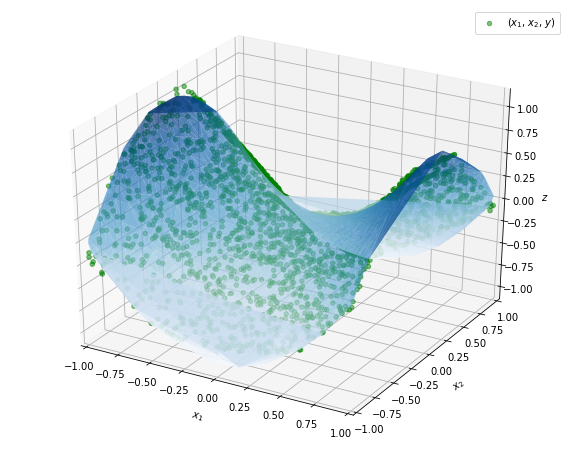

In [32]:
# (x1, x2, z) surface plot with (x1, x2, y_hat) scatterplot overlaid
surface = surface_plot(test_data["x1"], test_data["x2"], compute_z(test_data), zlabel="\n$z$")
surface.scatter(test_data["x1"], test_data["x2"], y_hat_test, label="($x_1$, $x_2$, $y$)", c="g", alpha=0.5)

plt.legend()
plt.show()

It's difficult to determine exactly where the model performed well and where it didn't using just this 3D representation. We can make this plot interactive by adding ```%matplotlib widget``` to the very first Python cell and rebuilding this plot, but, even when we do so, differences in performance are hard to see.

I think this is because the model performed well. The predicted values lie extremely close to the saddle at almost every $(x_1, x_2)$ point. This is indicative of the model's strong performance.

However, there are noticeable discrepancies at some of the extremes. For example, the model seems to underpredict when $x_1=-1$, but it doesn't seem to do so (as obviously) near the middle of the plot. It's possible that this happens because the model tries to predict $z$ using the mean $y$ value (or close to it) for an area; at the edges of the plot, there are fewer $(x_1, x_2, y)$ points that the model can use to identify a mean $y$ value for an area.

### 10b: Determine, display, and discuss the histogram of prediction errors from the predictions on the test set

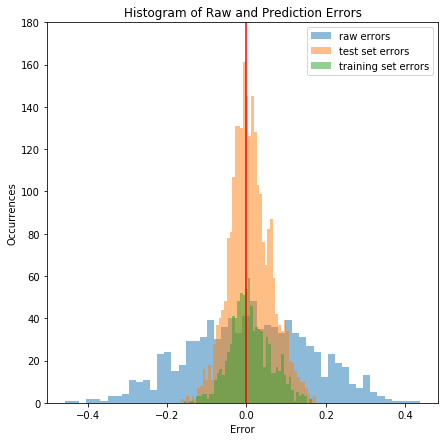

In [33]:
# compute the prediction errors
y_diff_test = y_hat_test - test_y

# create the figure
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

# pretty-fy the subplot
ax.set_xlabel("Error")
ax.set_ylabel("Occurrences")
ax.set_title("Histogram of Raw and Prediction Errors")

# plot it
ax.hist(y_diff_raw, bins=50, alpha=0.5, label="raw errors")
ax.hist(y_diff_test, bins=50, alpha=0.5, label="test set errors")
ax.hist(y_diff_train, bins=50, alpha=0.5, label="training set errors")

# add a vertical line at error = 0
ax.set_ylim(0, 180)
ax.plot([0, 0], [0, 180], c="r")

plt.legend()
plt.show()

We can see from the histograms above that the model effectively predicts the test-set $z$-values. The range of test errors is only slightly wider than the range of training set errors; this seems to indicate that the model did not overfit the training data. Of course, this is because we selected this model based on the *validation set's* MSE, so this is not at all unexpected.

Like with the training set errors, the histogram of test set errors is slightly skewed to the right of $0$. This is further evidence that the model overestimates $z$ more often than it underestimates $z$.

The test set errors are (mostly) normally-distributed about $0$ (or just to the right of $0$), so we know that the model correctly predicts $z$ in most cases. We also know that, when the model mispredicts, it most often mispredicts by only a bit.

Finally, we can see that the model tends to mispredict the test set in about the same way as it mispredicts the training set. In other words, the histograms have very similar shapes when we normalize the number of occurrences.

### 10c: Display and discuss the residuals

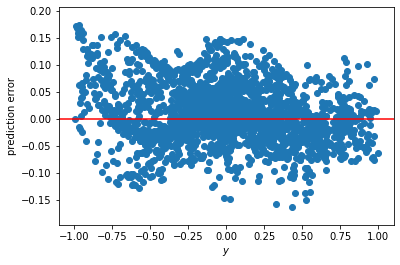

In [34]:
# scatter y vs prediction errors
plt.scatter(test_y, y_diff_test)
plt.xlabel("$y$")
plt.ylabel("prediction error")

# add a horizontal line at error = 0
plt.xlim(-1.1, 1.1)
plt.plot([-1.1, 1.1], [0,0], c="r")

plt.show()

At all but the greatest $y$ values (e.g., $y\geq 0.675$), the model overestimates $y$ more often than it underestimates. At the rightmost edge of the plot, however, we see that the model more often underestimates $y$.

Additionally, we can see that the model's worst estimates occur when $y=-1$ and $0\leq y\leq 0.6$, but these worst estimates only constitute 20-30 or so of the many points with a $y$ value in that range. In fact, the bulk of the prediction errors lie between $-0.1$ and $0.1$, and, aside from the 20-30 or so points that mispredict by more than $0.15$ units, there aren't really any outliers. We can thus say that the model performs consistently-well. It's not perfect, but most of its $y$-value predictions are fairly close to the correct value (if not exactly correct, as many of the predictions are).

Finally, we can see that the model tends to perform best at about $y=0$. Conversely, the model performs worst near the left and right edges of the plot. Again, this might be because the dataset contains fewer points with extreme $y$-values.

### 10d: Determine and report the error measures on the test set predictions

In [35]:
print("Raw error metrics")
print("    MSE  :", np.mean(y_diff_raw ** 2))
print("    RMSE :", np.sqrt(np.mean(y_diff_raw ** 2)))
print("    MAE  :", np.mean(np.abs(y_diff_raw)))
print()

print("Training set error metrics")
print("    MSE  :", np.mean(y_diff_train ** 2))
print("    RMSE :", np.sqrt(np.mean(y_diff_train ** 2)))
print("    MAE  :", np.mean(np.abs(y_diff_train)))
print()

print("Test set error metrics")
print("    MSE  :", np.mean(y_diff_test ** 2))
print("    RMSE :", np.sqrt(np.mean(y_diff_test ** 2)))
print("    MAE  :", np.mean(np.abs(y_diff_test)))

Raw error metrics
    MSE  : 0.02363522500631578
    RMSE : 0.15373751983922396
    MAE  : 0.12465195801133513

Training set error metrics
    MSE  : 0.0027413410250006587
    RMSE : 0.05235781722914601
    MAE  : 0.04026160157020059

Test set error metrics
    MSE  : 0.0028303195601637856
    RMSE : 0.05320074774064539
    MAE  : 0.04116512142645713


The model's test set error metrics are very similar to its training set error metrics. As previously stated, these metrics significantly outperform those of the raw errors in the non-test data. We can conclude that the model accurately fits the saddle, especially when compared to the noisy $y$-values in the non-test dataset.